# Installing Requirements + Setup
Goal of this Hackathon: **Classify digits (0-9) from a diverse dataset of handwritten, printed, and billboard text**

In [ ]:
!pip install datasets transformers torch

In [ ]:
!pip install --upgrade Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 74.3 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing Dataset + Augmentation


In [ ]:
%cd /content/drive/MyDrive/ChestScans

/content/drive/MyDrive/ChestScans


Data/test/normal/11 - Copy - Copy.png_inverted.png


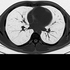

Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000106 (7).png_inverted.png


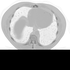

Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000009 (3).png_inverted.png


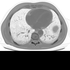

Data/test/normal/10 (2).png


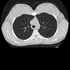

Data/train/normal/16 - Copy (2) - Copy.png_inverted.png


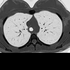

Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000059 (7).png


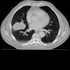

Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000118 (4).png_inverted.png


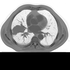

Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000019 (4).png_inverted.png


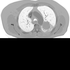

Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (6).png


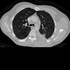

Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000095 (3).png_inverted.png


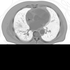

Data/test/adenocarcinoma/000139.png_inverted.png


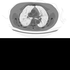

Data/train/normal/17 - Copy.png_inverted.png


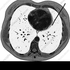

Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000057.png_inverted.png


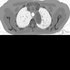

Data/test/adenocarcinoma/000146 (3).png


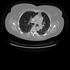

Data/test/adenocarcinoma/000158 (6).png


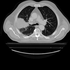

Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000040 (3).png_inverted.png


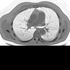

Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000035 (5).png


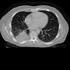

Data/test/squamous.cell.carcinoma/000160 (4).png


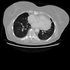

Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000074 (5).png


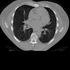

Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/l2.png


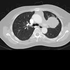

In [ ]:
import glob
import random
from PIL import Image, ImageOps

files = glob.glob("Data/**/*.png", recursive=True)

size = 70

for _ in range(20):
    # Test Transformations
    choice = random.choice(files)
    print(choice)
    img = Image.open(choice)
    img = ImageOps.contain(img, (70, 70), Image.Resampling.LANCZOS)
    

    img = ImageOps.pad(img, (70, 70), centering=(0,0))

    img = ImageOps.grayscale(img)

    img = ImageOps.autocontrast(img)
    display(img)


## Rationale
The images given are of different:
- sizes
- contrast
- colors
- brightness

To increase the performance of our model, we should do our best to make these images the same.
- Make sizes the same by using "contain" resize, so we keep the aspect ratio and add padding to make them the same size.
- Adjust the contrast so that the numbers stand out from their background.
- Convert the image to grayscale = **Image Version 1**
- Invert the grayscale image (black to white & white to black) = **Image Version 2**

These last two steps help handle images in the test set where some end up with the text being white, while others end up with their text being black.

Final result = preprocessed + augmented dataset too since we save both Image Version 1 and Image Version 2.

In [ ]:
IMG_SIZE = 224
failed = []


def transform_images(files):
    files_num = len(files)
    for id_file, file in enumerate(files):
        try:
            image = Image.open(file)
            image = ImageOps.contain(image, (IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
            
            image = ImageOps.grayscale(image)
            image = ImageOps.autocontrast(image)
            inverted = ImageOps.invert(image)

            image = ImageOps.pad(image, (IMG_SIZE, IMG_SIZE), centering=(0, 0))
            inverted = ImageOps.pad(inverted, (IMG_SIZE, IMG_SIZE), centering=(0, 0))

            inverted = inverted.convert("RGB")
            image = image.convert("RGB")

            inverted.save(f"{file}_inverted.png")
            image.save(file)

        except ValueError:
            failed.append(file)
        print(f"{id_file + 1} out of {files_num} File: {file.strip()}", end="\r")


transform_images(files)

# Loading Processed Dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="./Data/train")

Resolving data files:   0%|          | 0/1214 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-96940e854a7f79ee/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
data = dataset["train"].train_test_split(test_size=0.1)

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1092
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 122
    })
})

# Initialize Training
I chose ViT for this as it is one of the state-of-the art models at this time.
The rationale behind choosing the variant finetuned on the imagenet as well was to perhaps harness the benefits of transfer learning. Unfortunately, I was not able to validate this hypothesis as there was not enough time.

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
model_name_or_path = 'google/vit-large-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

labels = data['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/504 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-large-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
labels

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [ ]:
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs

In [ ]:
process_example(data["train"][0])

{'pixel_values': tensor([[[[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]]), 'label': 1}

In [ ]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

In [ ]:
prepared_data = data.with_transform(transform)

In [ ]:
import torch
import numpy as np
from datasets import load_metric

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


<ipython-input-11-2d4ecde2d74f>:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-digit-recognition",
  per_device_train_batch_size=8,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=15,
  fp16=True,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  warmup_ratio=0.1,
  remove_unused_columns=False,
  push_to_hub=False,
  metric_for_best_model="accuracy",
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_data["train"],
    eval_dataset=prepared_data["test"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1092
  Num Epochs = 15
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2055
  Number of trainable parameters = 303305732


Epoch,Training Loss,Validation Loss,Accuracy
1,0.764800,0.674034,0.672131
2,0.698900,0.750674,0.704918
3,0.536400,0.561269,0.729508
4,0.466200,0.788453,0.688525
5,0.267700,0.652789,0.852459
6,0.080500,0.830987,0.836066
7,0.002100,1.309018,0.770492
8,0.068800,0.747309,0.860656
9,0.027900,0.717770,0.877049
10,0.029800,0.391535,0.934426


***** Running Evaluation *****
  Num examples = 122
  Batch size = 8
Saving model checkpoint to ./vit-digit-recognition/checkpoint-137
Configuration saved in ./vit-digit-recognition/checkpoint-137/config.json
Model weights saved in ./vit-digit-recognition/checkpoint-137/pytorch_model.bin
Image processor saved in ./vit-digit-recognition/checkpoint-137/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 122
  Batch size = 8
Saving model checkpoint to ./vit-digit-recognition/checkpoint-274
Configuration saved in ./vit-digit-recognition/checkpoint-274/config.json
Model weights saved in ./vit-digit-recognition/checkpoint-274/pytorch_model.bin
Image processor saved in ./vit-digit-recognition/checkpoint-274/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 122
  Batch size = 8
Saving model checkpoint to ./vit-digit-recognition/checkpoint-411
Configuration saved in ./vit-digit-recognition/checkpoint-411/config.json
Model weights saved in ./vit-digit-

***** train metrics *****
  epoch                    =         15.0
  total_flos               = 4178911627GF
  train_loss               =        0.218
  train_runtime            =   0:40:20.38
  train_samples_per_second =        6.768
  train_steps_per_second   =        0.849


In [ ]:
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         15.0
  total_flos               = 4178911627GF
  train_loss               =        0.218
  train_runtime            =   0:40:20.38
  train_samples_per_second =        6.768
  train_steps_per_second   =        0.849


In [ ]:
metrics = trainer.evaluate(prepared_data["test"])

***** Running Evaluation *****
  Num examples = 122
  Batch size = 8


In [ ]:
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       15.0
  eval_accuracy           =     0.9344
  eval_loss               =     0.3915
  eval_runtime            = 0:01:09.48
  eval_samples_per_second =      1.756
  eval_steps_per_second   =       0.23


In [ ]:
# Confusion Matrix
import torch
import torch.nn.functional as F
from sklearn import metrics
import copy
 
y_preds = []
y_trues = []
for index,val_item in enumerate(data["test"]):
     encoding = feature_extractor(val_item["image"], return_tensors="pt").to("cuda")
     outputs = model(**encoding)
     y_pred = outputs.logits.argmax(-1)
     y_true = val_item["label"]
     y_preds.append(y_pred)
     y_trues.append(y_true)
     print(f"{index} out of {len(data['test'])}")
     

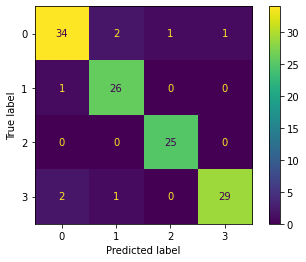

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
cm = metrics.confusion_matrix([int(x) for x in y_trues], [x.item() for x in y_preds], labels=[x for x in range(4)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
!cp -r "vit-digit-recognition/checkpoint-1370" /content/drive/MyDrive/ChestScans

In [ ]:
!zip -r "checkpoint-1370.zip" "vit-digit-recognition/checkpoint-1370"

  adding: vit-digit-recognition/checkpoint-1370/ (stored 0%)
  adding: vit-digit-recognition/checkpoint-1370/config.json (deflated 55%)
  adding: vit-digit-recognition/checkpoint-1370/pytorch_model.bin (deflated 7%)
  adding: vit-digit-recognition/checkpoint-1370/preprocessor_config.json (deflated 47%)
  adding: vit-digit-recognition/checkpoint-1370/training_args.bin (deflated 48%)
  adding: vit-digit-recognition/checkpoint-1370/optimizer.pt (deflated 8%)
  adding: vit-digit-recognition/checkpoint-1370/scheduler.pt (deflated 49%)
  adding: vit-digit-recognition/checkpoint-1370/scaler.pt (deflated 55%)
  adding: vit-digit-recognition/checkpoint-1370/trainer_state.json (deflated 82%)
  adding: vit-digit-recognition/checkpoint-1370/rng_state.pth (deflated 28%)


# Get Results
The test files can have many digits in one photo, so we first crop these according to the bounding boxes given.

In [ ]:
import glob, json
test_images = glob.glob("hackathon-online-2022-image-processing/IM_Test/**/*.png", recursive=True)
raw_bboxes = json.load(open("hackathon-online-2022-image-processing/IM_Test/IM_Test.json"))


In [ ]:
file_to_bbox = dict()
for raw_bbox in raw_bboxes:
    file_to_bbox[raw_bbox["filename"]] = raw_bbox["bboxes"]

In [ ]:
file_to_bbox

{'1.png': [{'bbox_id': 0, 'x1': 43, 'x2': 62, 'y1': 7, 'y2': 37}],
 '2.png': [{'bbox_id': 0, 'x1': 99, 'x2': 113, 'y1': 5, 'y2': 28},
  {'bbox_id': 1, 'x1': 114, 'x2': 122, 'y1': 8, 'y2': 31},
  {'bbox_id': 2, 'x1': 121, 'x2': 133, 'y1': 6, 'y2': 29}],
 '3.png': [{'bbox_id': 0, 'x1': 61, 'x2': 72, 'y1': 6, 'y2': 22}],
 '4.png': [{'bbox_id': 0, 'x1': 32, 'x2': 46, 'y1': 6, 'y2': 23}],
 '5.png': [{'bbox_id': 0, 'x1': 97, 'x2': 116, 'y1': 28, 'y2': 56}],
 '6.png': [{'bbox_id': 0, 'x1': 40, 'x2': 47, 'y1': 11, 'y2': 34}],
 '7.png': [{'bbox_id': 0, 'x1': 44, 'x2': 53, 'y1': 7, 'y2': 28},
  {'bbox_id': 1, 'x1': 51, 'x2': 62, 'y1': 6, 'y2': 27},
  {'bbox_id': 2, 'x1': 62, 'x2': 72, 'y1': 6, 'y2': 27}],
 '8.png': [{'bbox_id': 0, 'x1': 62, 'x2': 76, 'y1': 16, 'y2': 39},
  {'bbox_id': 1, 'x1': 80, 'x2': 94, 'y1': 17, 'y2': 40}],
 '9.png': [{'bbox_id': 0, 'x1': 27, 'x2': 39, 'y1': 8, 'y2': 26},
  {'bbox_id': 1, 'x1': 40, 'x2': 53, 'y1': 5, 'y2': 23},
  {'bbox_id': 2, 'x1': 52, 'x2': 67, 'y1': 7, 

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
model_name_or_path = "drive/MyDrive/vit/checkpoint-20610"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

labels = data['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
).to("cuda")

In [ ]:
!pip install pillow==9.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 7.3 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [ ]:
from PIL import Image, ImageOps
import torch

answers_final = dict()

with torch.no_grad():
    for img_id, image_path in enumerate(test_images):
        key = image_path.split("/")[-1]
        bbox = file_to_bbox[key]


        for box in bbox:
            img = Image.open(image_path)
            boxed = img.crop((box["x1"], box["y1"], box["x2"], box["y2"]))
            
            # Transform those images
            image = ImageOps.contain(boxed, (224, 224), Image.Resampling.LANCZOS)
            image = ImageOps.autocontrast(image)
            image = ImageOps.grayscale(image)
            image = ImageOps.autocontrast(image)
            image = ImageOps.pad(image, (224, 224), centering=(0, 0))
            image = image.convert("RGB")

            encoding = feature_extractor(image, return_tensors="pt").to("cuda")
            outputs = model(**encoding)
            pred = outputs.logits.argmax(-1).item()
            answers_final[f"{key.split('.')[0]}_{box['bbox_id']}"] = model.config.id2label[str(pred)]
        print(f"Image {img_id + 1} out of {len(test_images)}")

Streaming output truncated to the last 5000 lines.
Image 8069 out of 13068
Image 8070 out of 13068
Image 8071 out of 13068
Image 8072 out of 13068
Image 8073 out of 13068
Image 8074 out of 13068
Image 8075 out of 13068
Image 8076 out of 13068
Image 8077 out of 13068
Image 8078 out of 13068
Image 8079 out of 13068
Image 8080 out of 13068
Image 8081 out of 13068
Image 8082 out of 13068
Image 8083 out of 13068
Image 8084 out of 13068
Image 8085 out of 13068
Image 8086 out of 13068
Image 8087 out of 13068
Image 8088 out of 13068
Image 8089 out of 13068
Image 8090 out of 13068
Image 8091 out of 13068
Image 8092 out of 13068
Image 8093 out of 13068
Image 8094 out of 13068
Image 8095 out of 13068
Image 8096 out of 13068
Image 8097 out of 13068
Image 8098 out of 13068
Image 8099 out of 13068
Image 8100 out of 13068
Image 8101 out of 13068
Image 8102 out of 13068
Image 8103 out of 13068
Image 8104 out of 13068
Image 8105 out of 13068
Image 8106 out of 13068
Image 8107 out of 13068
Image 8108 ou

In [ ]:
answers_final

{'7923_0': '2',
 '7923_1': '1',
 '7923_2': '7',
 '7923_3': '6',
 '12513_0': '1',
 '12513_1': '1',
 '12513_2': '4',
 '5396_0': '2',
 '5396_1': '0',
 '5396_2': '9',
 '2734_0': '3',
 '2734_1': '1',
 '6510_0': '6',
 '6510_1': '2',
 '1106_0': '8',
 '1106_1': '6',
 '11086_0': '9',
 '4402_0': '7',
 '5061_0': '0',
 '7402_0': '7',
 '10098_0': '6',
 '10098_1': '7',
 '826_0': '1',
 '826_1': '3',
 '826_2': '3',
 '11841_0': '2',
 '11841_1': '6',
 '11841_2': '3',
 '8129_0': '2',
 '8129_1': '0',
 '8129_2': '4',
 '1667_0': '5',
 '1667_1': '2',
 '4531_0': '3',
 '4531_1': '2',
 '10096_0': '2',
 '1342_0': '1',
 '1342_1': '1',
 '1342_2': '3',
 '6236_0': '9',
 '6236_1': '0',
 '4240_0': '8',
 '4240_1': '7',
 '4240_2': '4',
 '10218_0': '3',
 '10218_1': '0',
 '5604_0': '1',
 '5604_1': '7',
 '5895_0': '1',
 '5895_1': '5',
 '104_0': '1',
 '11798_0': '2',
 '11798_1': '9',
 '11254_0': '2',
 '9364_0': '1',
 '9364_1': '3',
 '11717_0': '5',
 '11206_0': '5',
 '11206_1': '2',
 '430_0': '2',
 '430_1': '3',
 '4871_0': '

In [ ]:
with open("solution_best.csv", "w") as f:
    f.write("imageid_boxid,class\n")
    for name in answers_final:
        f.write(f"{name},{answers_final[name]}\n")